# Convolutional Neural Network

In [2]:
import pandas as pd
from finlab.data import Data
data = Data()
twii = data.get("發行量加權股價指數")
twii = twii['台股指數']
twii = twii.resample('15T').first().dropna()

## 製作features

In [187]:
import numpy as np
import tqdm
time_period = 200

cnn_x = []
cnn_y = []
indexs = []
for i in tqdm.tqdm_notebook(range(0, len(twii) - time_period - 1 - 11, 3)):
    s = twii.iloc[i:i+time_period].values
    cnn_x.append((s - s.min())/(s.max() - s.min()))
    r = twii.iloc[i+time_period+10] / twii.iloc[i+time_period-1]
    cnn_y.append(r)
    indexs.append(twii.index[i+time_period-1])

cnn_x = np.array(cnn_x)
cnn_y = np.array(cnn_y)
indexes = np.array(indexs)




## Reshape features and labels

In [146]:
cnn_x = cnn_x.reshape(len(cnn_x), time_period, 1)
cnn_y = cnn_y.reshape(len(cnn_y), 1)

## Split traning and testing data

In [147]:
import datetime
cnn_x_train = cnn_x[indexes < datetime.datetime(2016,1,1)]
cnn_y_train = cnn_y[indexes < datetime.datetime(2016,1,1)]

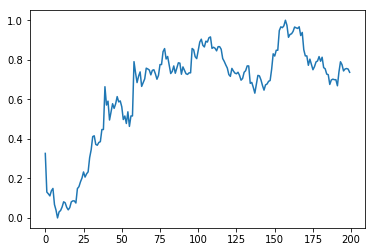

In [148]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(cnn_x[0].reshape(1, len(cnn_x[0]))[0])


## CNN

In [178]:
import keras.layers as layers
from keras.models import Sequential
from keras.initializers import he_normal

input_shape = cnn_x[0].shape
time_period = 200
num_classes = 1


model_m = Sequential()

model = keras.Sequential()

model.add(layers.Conv1D(filters=20, kernel_size=20, activation='relu', input_shape=cnn_x[0].shape))
model.add(layers.AveragePooling1D(5))

model.add(layers.Conv1D(filters=20, kernel_size=20, activation='relu'))
model.add(layers.AveragePooling1D(5))
model.add(layers.Flatten())
model.add(layers.Dense(units=120, activation='relu'))
model.add(layers.Dense(units=84, activation='relu'))
model.add(layers.Dense(units=1, ))#activation = 'softmax'))

adam = keras.optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.99, epsilon=None, decay=0.01, amsgrad=False)

model.compile(loss='mse',
                optimizer=adam, metrics=['accuracy'])

print(model.summary())

history = model.fit(cnn_x_train, cnn_y_train,
                    batch_size=200,
                    epochs=50,
                    verbose=1,
                    validation_split=0.1, )

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_112 (Conv1D)          (None, 181, 20)           420       
_________________________________________________________________
average_pooling1d_51 (Averag (None, 36, 20)            0         
_________________________________________________________________
conv1d_113 (Conv1D)          (None, 17, 20)            8020      
_________________________________________________________________
average_pooling1d_52 (Averag (None, 3, 20)             0         
_________________________________________________________________
flatten_26 (Flatten)         (None, 60)                0         
_________________________________________________________________
dense_86 (Dense)             (None, 120)               7320      
_________________________________________________________________
dense_87 (Dense)             (None, 84)                10164     
__________

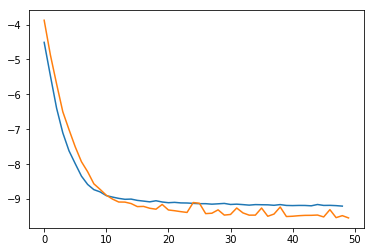

In [179]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(np.log(history.history['loss'][1:]))
plt.plot(np.log(history.history['val_loss']))

In [180]:
ey = model.predict(cnn_x)
ey = pd.Series(ey.swapaxes(0, 1)[0], index=indexes)

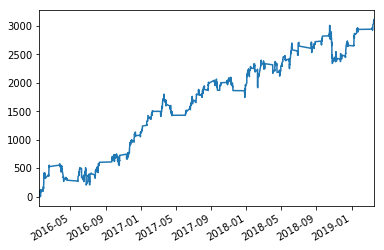

In [186]:

eq = twii[pd.to_datetime(indexes)]
gain = (eq.shift(-1) - eq) 

signal = (ey > ey.quantile(0.93)).rolling(20).sum() > 0
eq = (gain[signal])['2016':].cumsum()
eq.plot()

In [183]:
signal['2016':].astype(int).diff().abs().sum()

164.0